In [0]:
!wget -q https://raw.githubusercontent.com/HSE-CROSS-LING-DL/cma/master/data/trk-uncovered-train-transliterated.csv -O train.csv
!wget -q https://raw.githubusercontent.com/HSE-CROSS-LING-DL/cma/master/data/trk-uncovered-test-transliterated.csv -O test.csv
!wget -q https://raw.githubusercontent.com/HSE-CROSS-LING-DL/cma/master/data/trk-uncovered-dev-transliterated.csv -O dev.csv

In [0]:
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [3]:
!head test.csv

lang,word,lemma,pos,morph
krc,джыл,джыл,NOUN,Case=Nom
krc,эм,эм,ADV,_
krc,эм,эм,NOUN,Case=Nom
krc,джылны,джыл,NOUN,Case=Acc
krc,джылны,джыл,NOUN,Case=Gen
krc,болгъанды,бол,VERB,Number=Sing|Person=3|Tense=Past|Valency=1|VerbForm=Fin
krc,болгъанды,бол,VERB,Case=Nom|Tense=Past|Valency=1|VerbForm=Vnoun
krc,дери,де,VERB,"Case=Nom|Number[psor]=Sing,Plur|Person[psor]=3|Tense=Aor|Valency=2|VerbForm=Vnoun"
krc,кёре,кёр,VERB,Aspect=Impf|Valency=2|VerbForm=Conv


In [0]:
train_ = pd.read_csv('train.csv')
dev = pd.read_csv("dev.csv")
test = pd.read_csv('test.csv', sep=",")
data = train_[train_.lang!="bak"]

In [5]:
data.shape

(64637, 5)

In [6]:
data = data.dropna()
data = data.reset_index(drop=True)
data.shape

(64637, 5)

In [7]:
test = test.dropna()
test = test.reset_index(drop=True)
test.shape

(12926, 5)

In [8]:
dev = dev.dropna()
dev = dev.reset_index(drop=True)
dev.shape

(1245, 5)

### Additional preprocessing: reducing output features

In [0]:
post = {
    "2": "",
    "j": "й",
    "c": "с",
    "j": "ж",
    'ö': "ё",
    "ü": "ю",
    "ğ": "г",
    "ş": "ш",
    "і": "и",
    "ı": "ы",
    "қ": "к",
    "ң": "н",
    "ҫ": "ч",
    "ұ": "у",
    "ү": "у",
    "ә": "",
    'ө': "ё",
    "ё": "е",
    "w": "в",
    "â": "а",
    "u": "у",
    "î": "и"
}

def p(word):
    for char in post:
        word = word.replace(char, post[char])
    return word

def convert(word):
    chars = [char.strip() for char in word.replace("ъ", "").strip()]
    word = [char2index[char] if char in char2index else char2index["UNK"] for char in chars]
    return word

In [10]:
char2index = {"PAD": 0, "EOS": 1, "UNK": 2}
lengths = []


for word in tqdm(
    list(data.word.map(lambda x: p(x))) + 
    list(data.lemma.map(lambda x: p(x)))):
    l = len(word)
    lengths.append(l)
    for char in word:
        if char not in char2index:
            char2index[char] = len(char2index)

100%|██████████| 129274/129274 [00:00<00:00, 780134.38it/s]


In [11]:
test_lengths = []

for word in tqdm(
    set(test.word).union(set(test.lemma))
    ):
    l = len(word)
    test_lengths.append(l)

100%|██████████| 9232/9232 [00:00<00:00, 1738665.28it/s]


In [12]:
data = data[["lang", "word", "lemma"]]
data["word2char"] = data.word.map(lambda x: p(x)).apply(convert)
data["lemma2char"] = data.lemma.map(lambda x: p(x)).apply(convert)
data.head()

,lang,word,lemma,word2char,lemma2char
0,tat,казак,казак,"[3, 4, 5, 4, 3]","[3, 4, 5, 4, 3]"
1,tur,мuамеле,мuамеле,"[6, 7, 4, 6, 8, 9, 8]","[6, 7, 4, 6, 8, 9, 8]"
2,tat,заманы,заман,"[5, 4, 6, 4, 10, 11]","[5, 4, 6, 4, 10]"
3,tur,конuт,конuт,"[3, 12, 10, 7, 13]","[3, 12, 10, 7, 13]"
4,tur,корuмасы,корu,"[3, 12, 14, 7, 6, 4, 15, 11]","[3, 12, 14, 7]"


In [13]:
dev = dev[["lang", "word", "lemma"]]
dev["word2char"] = dev.word.map(lambda x: p(x)).apply(convert)
dev["lemma2char"] = dev.lemma.map(lambda x: p(x)).apply(convert)
dev.head()

,lang,word,lemma,word2char,lemma2char
0,crh,егленcелер,егленcе,"[8, 20, 9, 8, 10, 15, 8, 9, 8, 14]","[8, 20, 9, 8, 10, 15, 8]"
1,crh,сüргüнликниң,сüргüнлик,"[15, 28, 14, 20, 28, 10, 9, 24, 3, 10, 24, 10]","[15, 28, 14, 20, 28, 10, 9, 24, 3]"
2,crh,монархийада,монархийа,"[6, 12, 10, 4, 14, 32, 24, 27, 4, 16, 4]","[6, 12, 10, 4, 14, 32, 24, 27, 4]"
3,crh,кöстергенлери,кöстер,"[3, 8, 15, 13, 8, 14, 20, 8, 10, 9, 8, 14, 24]","[3, 8, 15, 13, 8, 14]"
4,crh,öксüз,öксüз,"[8, 3, 15, 28, 5]","[8, 3, 15, 28, 5]"


In [14]:
test = test[["lang", "word", "lemma"]]
test["word2char"] = test.word.map(lambda x: p(x)).apply(convert)
test["lemma2char"] = test.lemma.map(lambda x: p(x)).apply(convert)
test.head()

,lang,word,lemma,word2char,lemma2char
0,krc,джыл,джыл,"[16, 17, 11, 9]","[16, 17, 11, 9]"
1,krc,эм,эм,"[22, 6]","[22, 6]"
2,krc,эм,эм,"[22, 6]","[22, 6]"
3,krc,джылны,джыл,"[16, 17, 11, 9, 10, 11]","[16, 17, 11, 9]"
4,krc,джылны,джыл,"[16, 17, 11, 9, 10, 11]","[16, 17, 11, 9]"


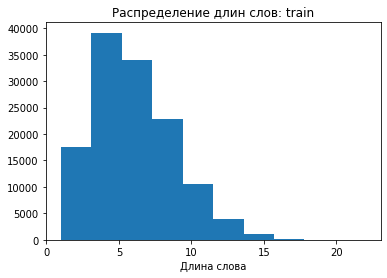

In [15]:
from matplotlib import pyplot as plt
import numpy as np


plt.title('Распределение длин слов: train')
plt.xlabel('Длина слова')
plt.hist(lengths)
plt.show()

In [16]:
# test
lengths = np.array([test_lengths])
np.percentile(test_lengths, q=95)

13.0

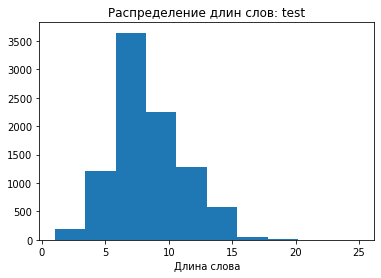

In [17]:
plt.title('Распределение длин слов: test')
plt.xlabel('Длина слова')
plt.hist(test_lengths)
plt.show()

## Data Loader

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import numpy as np
from sklearn.metrics import *


class CharLevelData(Dataset):
    def __init__(self, x_data, y_data, x_len, y_len, pad_index, eos_index):
        super(CharLevelData, self).__init__()
        self.x_data = x_data
        self.y_data = y_data
        self.x_len = x_len
        self.y_len = y_len
        self.pad_index = pad_index
        self.eos_index = eos_index

    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, index):
        encoder_sequence = self.x_data[index][:self.x_len]
        decoder_sequence = self.y_data[index][:self.y_len]
        
        target_sequence = decoder_sequence[:] + [self.eos_index]
        decoder_sequence = decoder_sequence[:]
        
        encoder_pads = [self.pad_index] * (self.x_len - len(encoder_sequence))
        decoder_pads = [self.pad_index] * (self.y_len - len(decoder_sequence))
        target_pads = [self.pad_index] * (self.y_len - len(decoder_sequence))
        
        encoder_sequence = torch.tensor(encoder_sequence + encoder_pads).long()
        decoder_sequence = torch.tensor(decoder_sequence + decoder_pads).long()
        target_sequence = torch.tensor(target_sequence + target_pads).long()
        
        return encoder_sequence, decoder_sequence, target_sequence

In [0]:
pad_index = 0
eos_index = 1
sos_index = 2
x_len = 10
y_len = 10

In [0]:
train_dataset = CharLevelData(data.word2char, data.lemma2char, x_len, y_len, pad_index, eos_index)
test_dataset = CharLevelData(test.word2char, test.lemma2char, x_len, y_len, pad_index, eos_index)
dev_dataset = CharLevelData(dev.word2char, dev.lemma2char, x_len, y_len, pad_index, eos_index)

In [0]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=256, shuffle=True)

## Модель

In [0]:
from tqdm import tqdm_notebook


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
for x, y, z in train_loader:
    break

In [24]:
x

tensor([[17,  4,  5,  ...,  0,  0,  0],
        [24, 36, 15,  ..., 15, 13, 24],
        [ 4, 21, 11,  ...,  0,  0,  0],
        ...,
        [18, 11, 34,  ...,  8, 10,  0],
        [12,  3, 18,  ...,  0,  0,  0],
        [27, 28,  3,  ..., 24,  0,  0]])

In [25]:
y

tensor([[17,  4,  5,  ...,  0,  0,  0],
        [24, 36, 15,  ..., 15, 13, 24],
        [ 4, 21, 11,  ...,  0,  0,  0],
        ...,
        [18, 11, 34,  ...,  0,  0,  0],
        [12,  3, 18,  ...,  0,  0,  0],
        [27, 28,  3,  ...,  0,  0,  0]])

In [26]:
z

tensor([[17,  4,  5,  ...,  0,  0,  0],
        [24, 36, 15,  ..., 13, 24,  1],
        [ 4, 21, 11,  ...,  0,  0,  0],
        ...,
        [18, 11, 34,  ...,  0,  0,  0],
        [12,  3, 18,  ...,  0,  0,  0],
        [27, 28,  3,  ...,  0,  0,  0]])

In [27]:
x.shape, y.shape, z.shape

(torch.Size([256, 10]), torch.Size([256, 10]), torch.Size([256, 11]))

In [0]:
config = {
    "embedding_size": 300,
    "vocab_size": len(char2index),
    "hidden_size": 300,
    "num_layers": 2,
    "dropout": 0.3,
    "pad_index": pad_index
}


def get_model_params(config):
    embedding_size = config.get("embedding_size")
    vocab_size = config.get("vocab_size")
    hidden_size = config.get("hidden_size")
    num_layers = config.get("num_layers")
    dropout = config.get("dropout")
    pad_index = config.get("pad_index")
    return embedding_size, vocab_size, hidden_size, num_layers, dropout, pad_index

In [0]:
embedding_size, vocab_size, hidden_size, num_layers, dropout, pad_index = get_model_params(config)

In [0]:
class SpatialDropout(torch.nn.Dropout2d):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
    
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x


class GRULMT(torch.nn.Module):
    def __init__(self, embedding_size, vocab_size, hidden_size, num_layers, dropout, pad_index):
        super(GRULmt, self).__init__()
        self.dropout = dropout
        self.embedding_layer = torch.nn.Embedding(vocab_size, embedding_size, pad_index)
        self.embedding_dropout = SpatialDropout(p=self.dropout)
        self.encoder = torch.nn.GRU(embedding_size, hidden_size, 
                                    num_layers=num_layers, dropout=self.dropout, batch_first=True,
                                    bidirectional=False)
        self.decoder = torch.nn.GRU(hidden_size, hidden_size, 
                                    num_layers=num_layers, dropout=self.dropout, batch_first=True)
        self.head = torch.nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, y):
        x = self.embedding_layer(x)
        x = self.embedding_dropout(x)
        y = self.embedding_layer(y)

        x_hidden, _ = self.encoder(x)
        y = torch.cat([x_hidden[:, -1, :].unsqueeze(1), y], dim=1)
        
        y_hidden, _ = self.decoder(y, _)
        prediction = self.head(y_hidden)

        return prediction

class BiGRULMT(torch.nn.Module):
    def __init__(self, embedding_size, vocab_size, hidden_size, num_layers, dropout, pad_index):
        super(BiGRULMT, self).__init__()
        self.dropout = dropout
        self.encoder_embedding = torch.nn.Embedding(vocab_size, embedding_size, pad_index)
        self.decoder_embedding = torch.nn.Embedding(vocab_size, embedding_size * 2, pad_index)
        self.embedding_dropout = SpatialDropout(p=self.dropout)
        self.encoder = torch.nn.GRU(embedding_size, hidden_size, 
                                    num_layers=num_layers, dropout=self.dropout, batch_first=True,
                                    bidirectional=True)
        self.decoder = torch.nn.GRU(hidden_size * 2, hidden_size, 
                                    num_layers=num_layers * 2, dropout=self.dropout, batch_first=True)
        self.head = torch.nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, y):
        x = self.encoder_embedding(x)
        x = self.embedding_dropout(x)
        y = self.decoder_embedding(y)

        x_hidden, _ = self.encoder(x)
        y = torch.cat([x_hidden[:, -1, :].unsqueeze(1), y], dim=1)
        
        y_hidden, _ = self.decoder(y, _)
        prediction = self.head(y_hidden)

        return prediction

In [0]:
def train(model, iterator, criterion, optimizer):
    
    model.train()

    losses_list = []
    epoch_loss = 0
    progress_bar = tqdm(iterator, total=len(iterator))
    
    for x, y, z in progress_bar:
        
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        z = z.to(device)

        output = model(x, y)

        output = output.view(-1, output.size(-1))
        z = z.view(-1)
        
        loss = criterion(output, z)
        losses_list.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        progress_bar.set_postfix(train_loss = np.mean(losses_list[-500:]))

        progress_bar.update(x.shape[0])
    progress_bar.close()
    return losses_list

def bi_train(model, iterator, criterion, encoder_optimizer, decoder_optimizer, clip):
    
    model.train()

    losses_list = []
    epoch_loss = 0
    progress_bar = tqdm(iterator, total=len(iterator))
    
    for x, y, z in progress_bar:
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        z = z.to(device)

        output = model(x, y)

        output = output.view(-1, output.size(-1))
        z = z.view(-1)
        
        loss = criterion(output, z)
        losses_list.append(loss.item())
        
        loss.backward()
        if clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        progress_bar.set_postfix(train_loss = np.mean(losses_list[-500:]))

        progress_bar.update(x.shape[0])
    progress_bar.close()
    return losses_list

In [32]:
model = BiGRULMT(embedding_size, vocab_size, hidden_size, num_layers, dropout, pad_index)
model.to(device)

BiGRULMT(
  (encoder_embedding): Embedding(41, 300, padding_idx=0)
  (decoder_embedding): Embedding(41, 600, padding_idx=0)
  (embedding_dropout): SpatialDropout(p=0.3, inplace=False)
  (encoder): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (decoder): GRU(600, 300, num_layers=4, batch_first=True, dropout=0.3)
  (head): Linear(in_features=300, out_features=41, bias=True)
)

In [0]:
optimizer = optim.Adam(model.parameters())

encoder_optimizer = optim.Adam(model.encoder.parameters())
decoder_optimizer = optim.Adam(model.decoder.parameters())

criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [0]:
# bi_train(model, train_loader, criterion, encoder_optimizer, decoder_optimizer, clip=False)

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
index2char = {index: char for char, index in char2index.items()}

In [0]:
def original_input(batch):
    original = []
    for elem in batch:
        original_elem = ""
        for index in elem:
            index = index.tolist()
            if index not in (pad_index, eos_index):
                original_elem += index2char[index]
        original.append(original_elem)
    return original


def original_output(batch):
    original = []
    for elem in batch:
        elem = elem.argmax(dim=1).tolist()
        original_elem = "".join([index2char[index] for index in elem
                        if index not in (pad_index, eos_index)])
        original.append(original_elem)
    return original

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
epochs = 20
clip = None
losses = []
best_test_loss = 10.


for n_epoch in range(epochs):

    precisions, recalls, fscores = [], [], []
    train_losses, test_losses = [], []

    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for instance in list(tqdm._instances):
        tqdm._decr_instances(instance)

    #curr_epoch_losses = train(model, train_loader, criterion, optimizer)
    curr_epoch_losses = bi_train(model, train_loader, criterion, encoder_optimizer, decoder_optimizer, clip)
    losses.extend(curr_epoch_losses)

    model.eval()

    for x, y, z in test_loader:
        
        x = x.to(device)
        y = y.to(device)
        z = z.to(device)

        with torch.no_grad():

            output = model(x, y)
            
            eval_x = original_output(output)
            eval_y = original_input(y)

            output = output.view(-1, output.size(-1))

            z = z.view(-1)
            loss = criterion(output, z)

            test_losses.append(loss.item())
            F = f1_score(eval_x, eval_y, average="macro")
            fscores.append(F)

    mean_test_loss = np.mean(test_losses)
    fscore = np.mean(fscores)


    print()
    print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(curr_epoch_losses), mean_test_loss))
    print("F1-score: {:.3f}".format(fscore))

    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Epoch 2:   0%|          | 0/64637 [00:00<?, ?it/s]
512it [00:00, 4042.60it/s, train_loss=0.657]


Losses: train - 1.346, test - 0.771
F1-score: 0.141


Epoch 3:   0%|          | 0/64637 [00:00<?, ?it/s]
512it [00:00, 3764.21it/s, train_loss=0.353]


Losses: train - 0.470, test - 0.487
F1-score: 0.222


Epoch 4:   0%|          | 0/64637 [00:00<?, ?it/s]
512it [00:00, 3942.55it/s, train_loss=0.268]


Losses: train - 0.310, test - 0.438
F1-score: 0.179


Epoch 5:   0%|          | 0/64637 [00:00<?, ?it/s]
512it [00:00, 4187.87it/s, train_loss=0.213]


Losses: train - 0.245, test - 0.381
F1-score: 0.263


Epoch 6:   0%|          | 0/64637 [00:00<?, ?it/s]
512it [00:00, 3565.19it/s, train_loss=0.187]


Losses: train - 0.207, test - 0.357
F1-score: 0.247


Epoch 7:   0%|          | 0/64637 [00:00<?, ?it/s]
512it [00:00, 4429.57it/s, train_loss=0.162]


Losses: train - 0.183, test - 0.342
F1-score: 0.247


Epoch 8:   0%|          | 0/64637 [00:00<?, ?it/s]
512it [00:00, 4266.83it/s, train_loss=0.17] 


Losses: train - 0.167, test - 0.339
F1-score: 0.192


Epoch 9:   0%|          | 0/64637 [00:00<?, ?it/s]
512it [00:00, 3911.19it/s, train_loss=0.142]


Losses: train - 0.154, test - 0.331
F1-score: 0.243


100%|██████████| 253/253 [00:15<00:00, 16.43it/s, train_loss=0.145]



Losses: train - 0.145, test - 0.345
F1-score: 0.230
Early stopping


In [44]:
model.eval()

test_losses, fscores = [], []

for x, y, z in dev_loader:
        
    x = x.to(device)
    y = y.to(device)
    z = z.to(device)

    with torch.no_grad():

        output = model(x, y)
            
        eval_x = original_output(output)
        eval_y = original_input(y)

        output = output.view(-1, output.size(-1))

        z = z.view(-1)
        loss = criterion(output, z)

        test_losses.append(loss.item())
        F = f1_score(eval_x, eval_y, average="macro")
        fscores.append(F)

mean_test_loss = np.mean(test_losses)
fscore = np.mean(fscores)


print()
print("F1-score: {:.3f}".format(fscore))


F1-score: 0.256


Text(0, 0.5, 'Loss function')

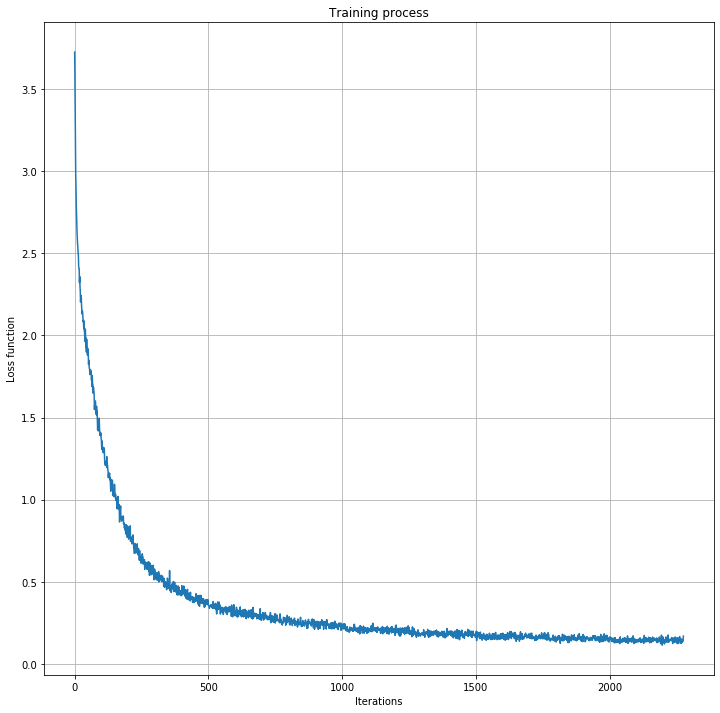

In [45]:
plt.figure(figsize=(12, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')